In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Float, Integer, String
from sqlalchemy import desc
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:

measurement = Base.classes.measurement
station = Base.classes.station
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Create our session (link) from Python to the DB

session = Session(bind=engine)

In [10]:
# Find the most recent date in the data set.

results = session.query(measurement).order_by(desc(measurement.date)).limit(1)
for result in results:
    recent_date= (result.date)
    print(f"Most recent date is {recent_date}")

# date= recent_date.split("-")
# year=date[0]
# month=date[1]
# day=date[2]
# print(f"{year} ,  {month}, {day}")

Most recent date is 2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
twelve_month_old_date =  (datetime.strptime(recent_date, "%Y-%m-%d") -  timedelta(days=365)).strftime("%Y-%m-%d") #relativedelta(years=1) 
print(twelve_month_old_date)


2016-08-23


In [12]:

# Perform a query to retrieve the data and precipitation scores


results = session.query(measurement).filter(measurement.date>=twelve_month_old_date).with_entities(measurement.date,measurement.prcp)
prcp_df=pd.DataFrame(results)
prcp_df.head()


,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00



date	prcp
0	2016-08-23	0.00
1	2016-08-24	0.08
2	2016-08-25	0.08
3	2016-08-26	0.00
4	2016-08-27	0.00

In [13]:

#Drop empty rows
prcp_df.dropna(inplace=True)

prcp_df.head()


,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [14]:

prcp_df["date"]= pd.to_datetime(prcp_df['date'], format='%Y-%m-%d')
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df.set_index(["date"], drop=True,inplace=True)
prcp_df.head()

# * Sort the DataFrame values by `date`.
prcp_df.sort_index()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


<Figure size 432x288 with 0 Axes>

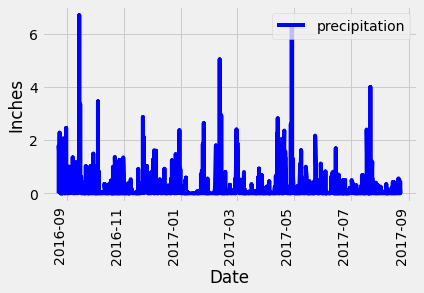

In [15]:

# * Plot the results using the DataFrame `plot` method.
plt.figure()
prcp_df.plot(y='prcp',color='blue', label="precipitation", rot=90)
prcp_df.to_excel("output.xlsx")  
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend( loc ="upper right")
plt.savefig("Precipitation.png")
plt.show()

Output file can be found in root folder called "Precipitation.png"

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(prcp_df.describe())

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
results = session.query(station).count()
print(results)


9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
query = sqlalchemy.select([
    measurement.station,
    sqlalchemy.func.count( measurement.station)
]).group_by( measurement.station)
result = engine.execute(query).fetchall()
df=pd.DataFrame(result)
df=df.sort_values(by='count_1', ascending=False)
df.reset_index()


,index,station,count_1
0,6,USC00519281,2772
1,7,USC00519397,2724
2,1,USC00513117,2709
3,8,USC00519523,2669
4,3,USC00516128,2612
5,2,USC00514830,2202
6,0,USC00511918,1979
7,4,USC00517948,1372
8,5,USC00518838,511


Here is output of DataFrame

index	station	   count_1

0	6	USC00519281	2772

1	7	USC00519397	2724

2	1	USC00513117	2709

3	8	USC00519523	2669

4	3	USC00516128	2612

5	2	USC00514830	2202

6	0	USC00511918	1979

7	4	USC00517948	1372

8	5	USC00518838	511

In [19]:
station_with_max_measurements = df.iloc[0,0]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

query = sqlalchemy.select([measurement.station,
sqlalchemy.func.min( measurement.tobs), 
sqlalchemy.func.max( measurement.tobs), 
sqlalchemy.func.avg( measurement.tobs)]).filter( measurement.station == station_with_max_measurements)
result = engine.execute(query).fetchall()
df=pd.DataFrame(result)
df.head()


,station,min_1,max_1,avg_1
0,USC00519281,54.0,85.0,71.663781


Min Max and Average for most active station

station	min_1	max_1	avg_1

0	USC00519281	54.0	85.0	71.663781

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#Find the most recent date for the station is most measurements
query = sqlalchemy.select(measurement).filter( measurement.station == station_with_max_measurements).order_by(desc(measurement.date)).limit(1)
results = engine.execute(query).fetchall()
for result in results:
    recent_date= (result.date)
print(recent_date)
twelve_month_old_date = (datetime.strptime(recent_date, "%Y-%m-%d") - timedelta(days=365)).strftime("%Y-%m-%d")
print(twelve_month_old_date)

2017-08-18
2016-08-18


In [22]:
#Create a data frame for last one year of results from station is most readings
results = session.query(measurement.date).filter((
    measurement.station == station_with_max_measurements) & (measurement.date>=twelve_month_old_date)).with_entities(measurement.date,measurement.tobs)
df=pd.DataFrame(results)
#Drop the empty cells if any 
df.dropna(subset=['tobs'], inplace=True)


# Exploratory Precipitation Analysis

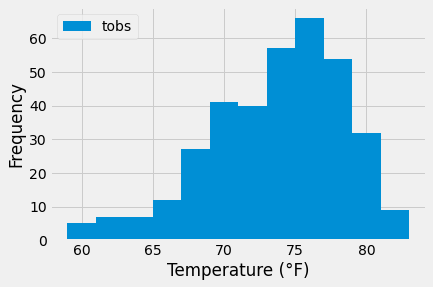

In [23]:
#Draw histogram with 12 bins.
plt.hist(df["tobs"],bins=12, label="tobs")
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend( loc ="upper left")
plt.savefig("tobs.png")
plt.show()

Output is saved in "tobs.png"

In [24]:

df.describe()


,tobs
count,357.000000
mean,73.196078
std,4.759460
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


Here is output from describe function
	
tobs

count	357.000000

mean	73.196078

std	4.759460

min	59.000000

25%	70.000000

50%	74.000000

75%	77.000000

max	83.000000


# Close session

In [25]:
# Close Session
session.close()



In [26]:
#Below is some code used to test the flask output. It ns not needed for this activity and hence commented out
# def start(start):
#     # Create our session (link) from Python to the DB
#     session = Session(engine)
#     query = sqlalchemy.select([measurement,
#     sqlalchemy.func.min( measurement.tobs), 
#     sqlalchemy.func.max( measurement.tobs), 
#     sqlalchemy.func.avg( measurement.tobs)]).filter( measurement.date > start)
#     result = engine.execute(query).fetchall()
#     df=pd.DataFrame(result)
#     df=df.loc[:,["min_1", "max_1","avg_1"]]
#     df=df.rename(columns={"min_1":"minimum", "max_1":"maximum", "avg_1":"average"})
#     print(df.head())
#     dict1=df.to_dict("records")
#     results = session.query(measurement).order_by(desc(measurement.date)).limit(1)
#     for result in results:
#         recent_date= (result.date)
#     print(f"Most recent date is {recent_date}")
#     results = session.query(measurement).order_by(measurement.date.asc()).limit(1)
#     for result in results:
#         oldest_date= (result.date)
#     print(f"Oldest date is {recent_date}")   

#     session.close()
#     return ( print(f" Date should be between {oldest_date} and  {recent_date} \n Here are results: \n {dict1}" )  )

# start("2016-08-10")


   minimum  maximum    average
0     58.0     87.0  74.703945
Most recent date is 2017-08-23
Oldest date is 2017-08-23
 Date should be between 2010-01-01 and  2017-08-23 
 Here are results: 
 [{'minimum': 58.0, 'maximum': 87.0, 'average': 74.70394451668834}]


In [27]:

# def window(start,end):
#     # Create our session (link) from Python to the DB
#     session = Session(engine)
#     query = sqlalchemy.select([measurement,
#     sqlalchemy.func.min( measurement.tobs), 
#     sqlalchemy.func.max( measurement.tobs), 
#     sqlalchemy.func.avg( measurement.tobs)]).filter((measurement.date > start) & (measurement.date < end))
#     result = engine.execute(query).fetchall()
#     df=pd.DataFrame(result)
#     df=df.loc[:,["min_1", "max_1","avg_1"]]
#     df=df.rename(columns={"min_1":"minimum", "max_1":"maximum", "avg_1":"average"})
#     dict1=df.to_dict("records")
#     session.close()
#     return ( dict1 )  
# window("2010-08-10", "2016-08-10")